In [79]:
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import h5py
import io
import math


hf = h5py.File('../data/data.h5', 'r')

In [2]:
def retreiveImages(file_path):

    train_img_names = hf['Anno_fine'][file_path]
    train_img_names = np.array(train_img_names)
    strip = np.vectorize(lambda x : x.strip())
    train_img_names = strip(train_img_names)
    
    train_imgs = []
    for img_name in tqdm(train_img_names):
        test_img = np.asarray(Image.open(io.BytesIO(np.array(hf[img_name]))))


        train_imgs.append(test_img)

    return train_imgs

In [3]:
def getSequence(file_name):
    ret = hf['Anno_fine'][file_name]
    ret = np.array(ret)
    ret = [[int(y) for y in x.strip().split()] for x in ret]
    return np.array(ret)

In [86]:
train_imgs = retreiveImages('train.txt')
train_attrs = getSequence('train_attr.txt')
train_categories = getSequence('train_cate.txt')
train_bboxs = getSequence('train_bbox.txt')
train_landmarks = getSequence('train_landmarks.txt')


In [107]:
import skimage.transform as st

def preprocess(index):
    img = train_imgs[index]
    target_size = 301

    y_diff = target_size - img.shape[0]
    x_diff = target_size - img.shape[1]

    x_diff_left = math.floor(x_diff/2)
    x_diff_right = math.ceil(x_diff/2)

    y_diff_up = math.floor(y_diff/2)
    y_diff_down = math.ceil(y_diff/2)

    left_padding = 255 * np.ones((img.shape[0], x_diff_left, 3), dtype=int)
    right_padding = 255 * np.ones((img.shape[0], x_diff_right, 3), dtype=int)

    new_img = np.hstack((left_padding, img, right_padding))

    up_padding = 255 * np.ones((y_diff_up, target_size, 3), dtype=int)
    down_padding = 255 * np.ones((y_diff_down, target_size, 3), dtype=int)

    new_img = np.vstack((up_padding, new_img, down_padding))
    
    new_img = st.resize(new_img, (224, 224))

    train_imgs[index] = new_img
    train_bboxs[index] = [sum(x) for x in zip(train_bboxs[index], [x_diff_left, y_diff_up] * 2)]
    train_landmarks[index] = [sum(x) for x in zip(train_landmarks[index], [x_diff_left, y_diff_up] * 8)]


In [108]:
for i in tqdm(range(len(train_imgs))):
    preprocess(i)

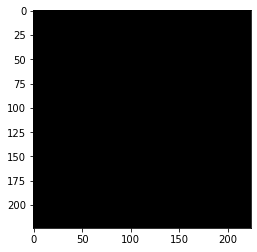

In [109]:

plt.imshow(train_imgs[2])